# Тест #1

## Вариант #4

**Журавский Максим, группа 520**

In [1]:
from covid19dh import covid19
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 300

In [2]:
x, src = covid19(country='Russia', level=1, start=date(2020, 4,3),verbose=False)
x = x[['date', 'vaccines', 'tests', 'confirmed', 'recovered', 'deaths']]
x.head()

,date,vaccines,tests,confirmed,recovered,deaths
59198,2020-04-03,NaN,639606.0,4149.0,281.0,34.0
59199,2020-04-04,NaN,697004.0,4731.0,333.0,43.0
59200,2020-04-05,NaN,758401.0,5389.0,355.0,45.0
59201,2020-04-06,NaN,795523.0,6343.0,406.0,47.0
59202,2020-04-07,NaN,910221.0,7497.0,494.0,58.0


Рассчитаем долю изменения ежедневного числа выздоровлений. Для первых двух изменений ее расчитать невозможно, поэтому отбросим данные наблюдения. Заметим, что среди оставшихся наблюдений пропущенных значений нет.

In [3]:
recovered = x[['date', 'confirmed']].copy().rename(columns={'confirmed': 'abs'}).reset_index(drop=True)
recovered['new'] = recovered['abs'] - recovered['abs'].shift(periods=1)
recovered['diff_perc'] = (recovered['new'] / recovered['new'].shift(periods=1)).map(lambda x: (x - 1) * 100)
recovered = recovered.loc[2:,:]
recovered_diff_perc = recovered[['diff_perc', 'date']].set_index('date')['diff_perc']
print('В ряде есть пропущенные значения: {}'.format(any(recovered['diff_perc'].isnull())))

В ряде есть пропущенные значения: False


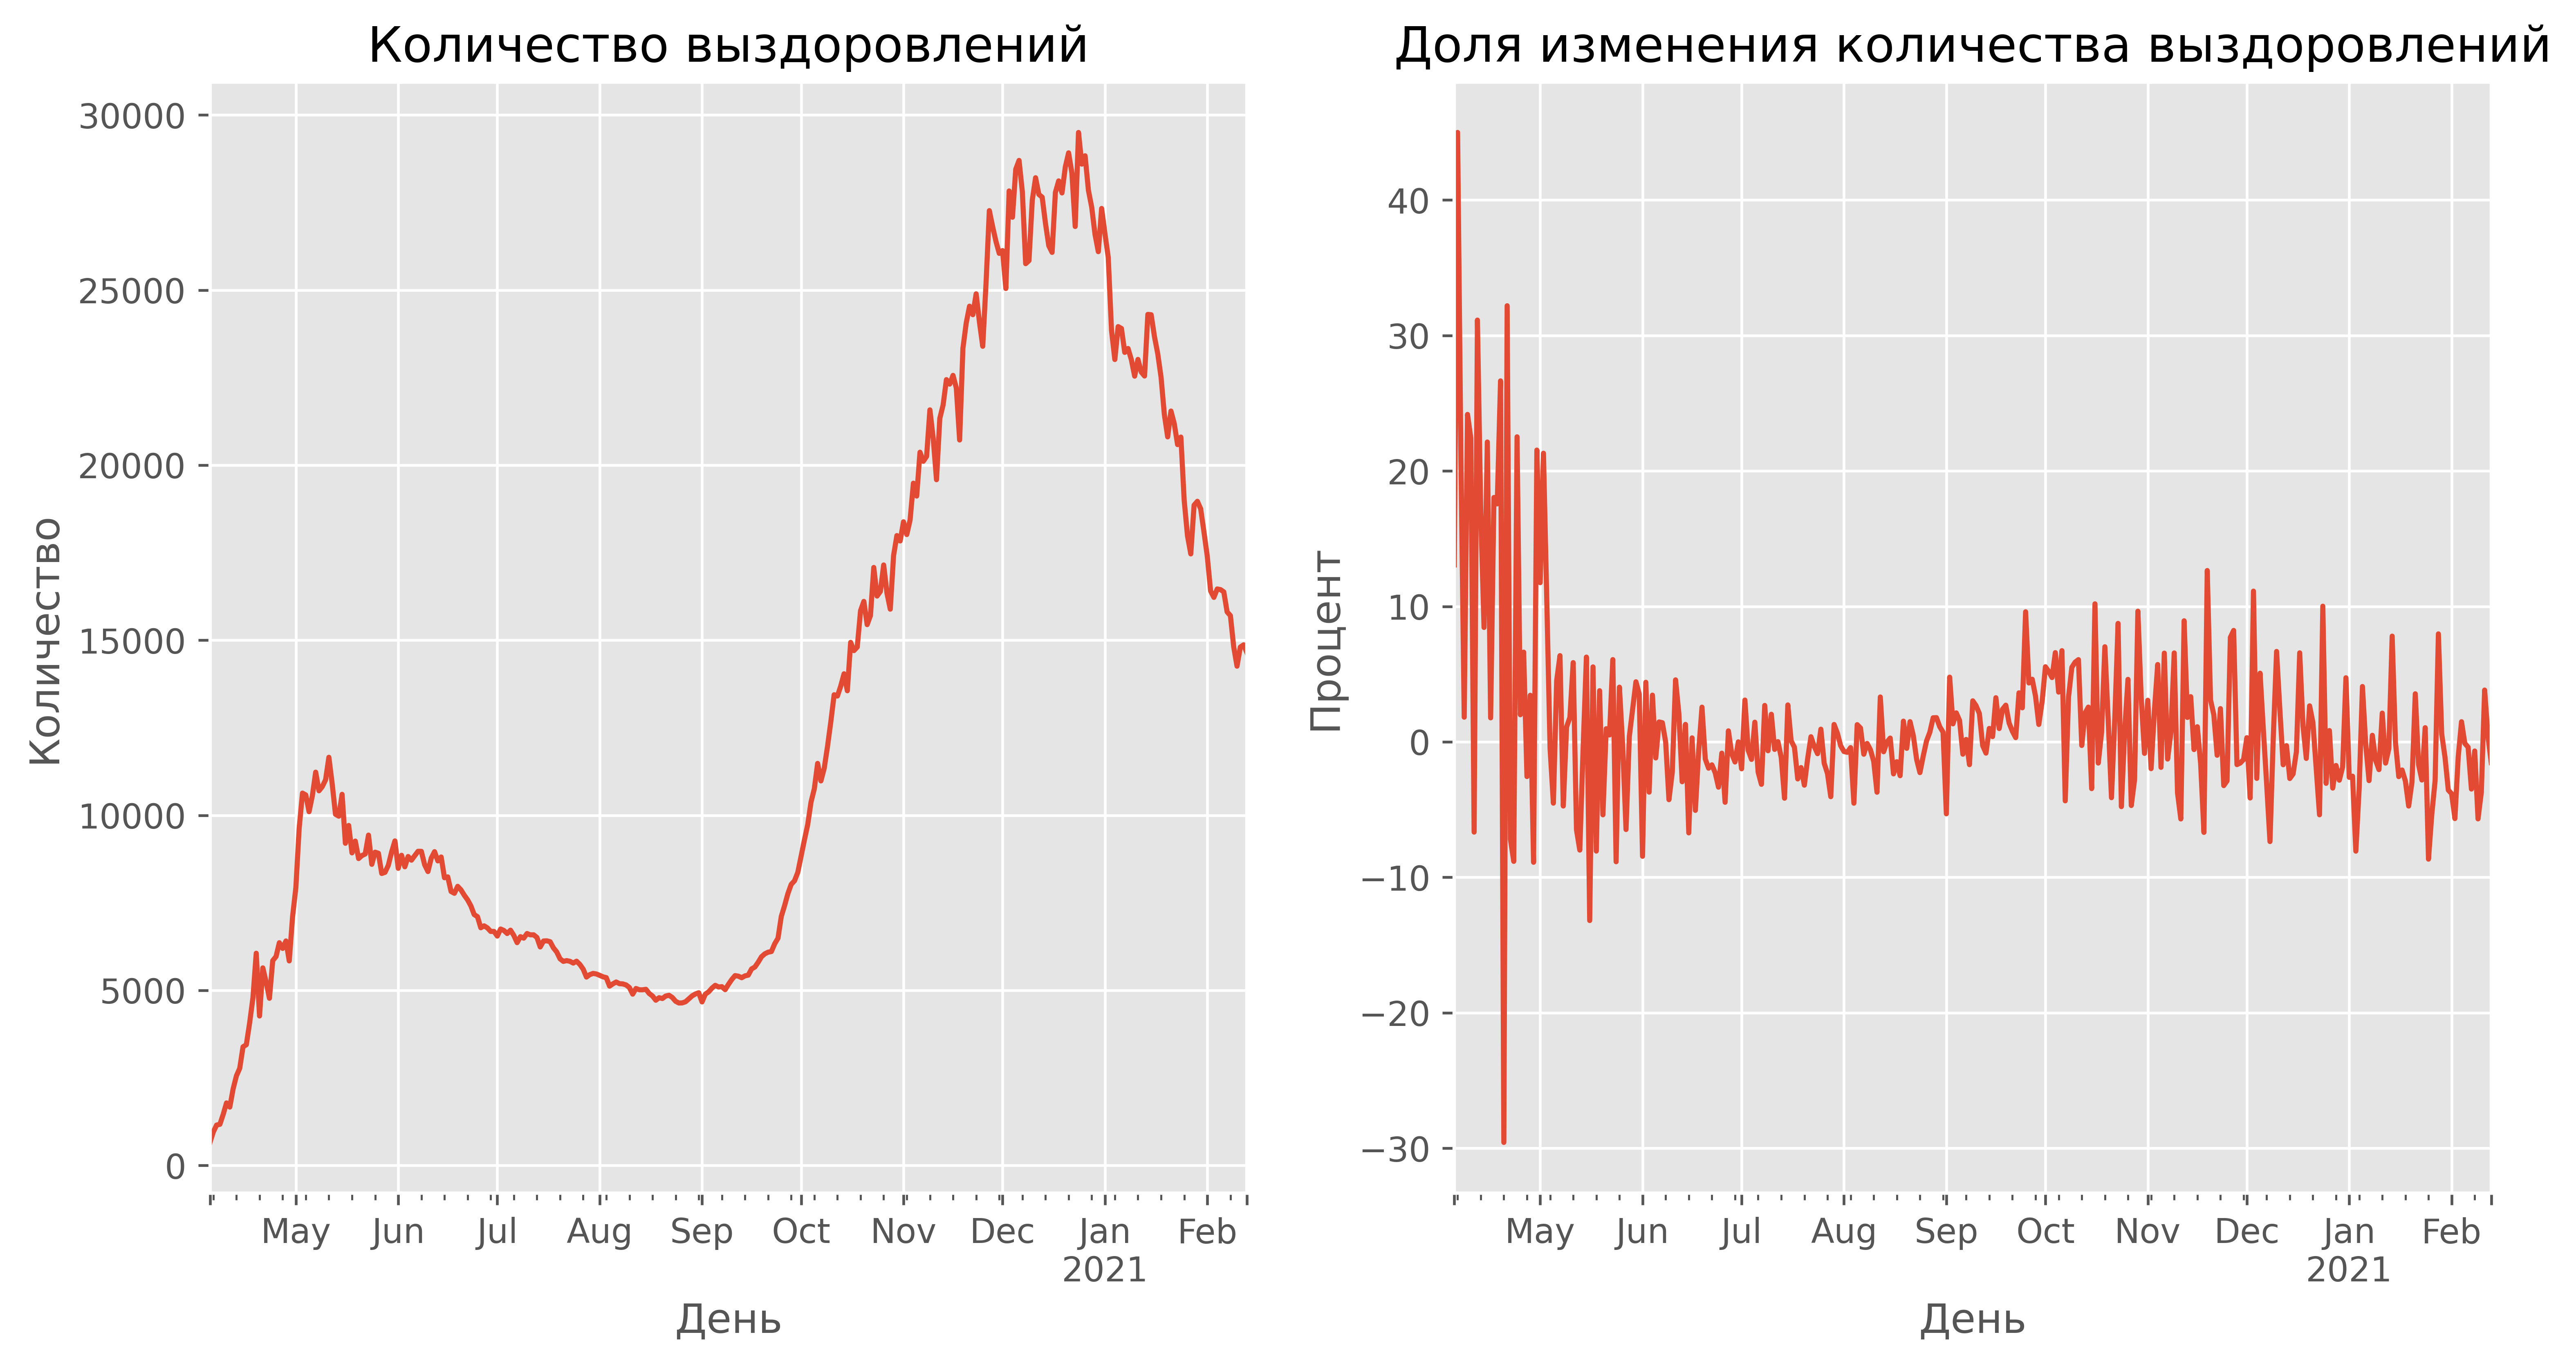

In [4]:
p, ax = plt.subplots(ncols=2)
recovered.plot(ax=ax[0], x='date', y='new')
ax[0].set_title('Количество выздоровлений')
ax[0].set_xlabel('День')
ax[0].set_ylabel('Количество')
ax[0].get_legend().remove()

recovered.plot(ax=ax[1], x='date', y='diff_perc')
ax[1].set_title('Доля изменения количества выздоровлений')
ax[1].set_xlabel('День')
ax[1].set_ylabel('Процент')
ax[1].get_legend().remove()

## Аддитивная модель

In [5]:
def group_seasonal_component(seasonal):
    df = seasonal.reset_index(name='perc')
    df['dow'] = df['date'].map(lambda x: x.dayofweek)
    return df.set_index('dow')['perc'][0:7].sort_index()

Построим аддитивную модель для временного ряда с периодом, равным одной неделе.

In [6]:
add_model = seasonal_decompose(recovered_diff_perc, model='additive', period=7)
add_seasonal = group_seasonal_component(add_model.seasonal)
add_residuals = recovered_diff_perc - add_model.seasonal

<AxesSubplot:title={'center':'Сезонная компонента аддитивной модели доли изменения числа выздоровлений'}, xlabel='День недели', ylabel='Процент'>

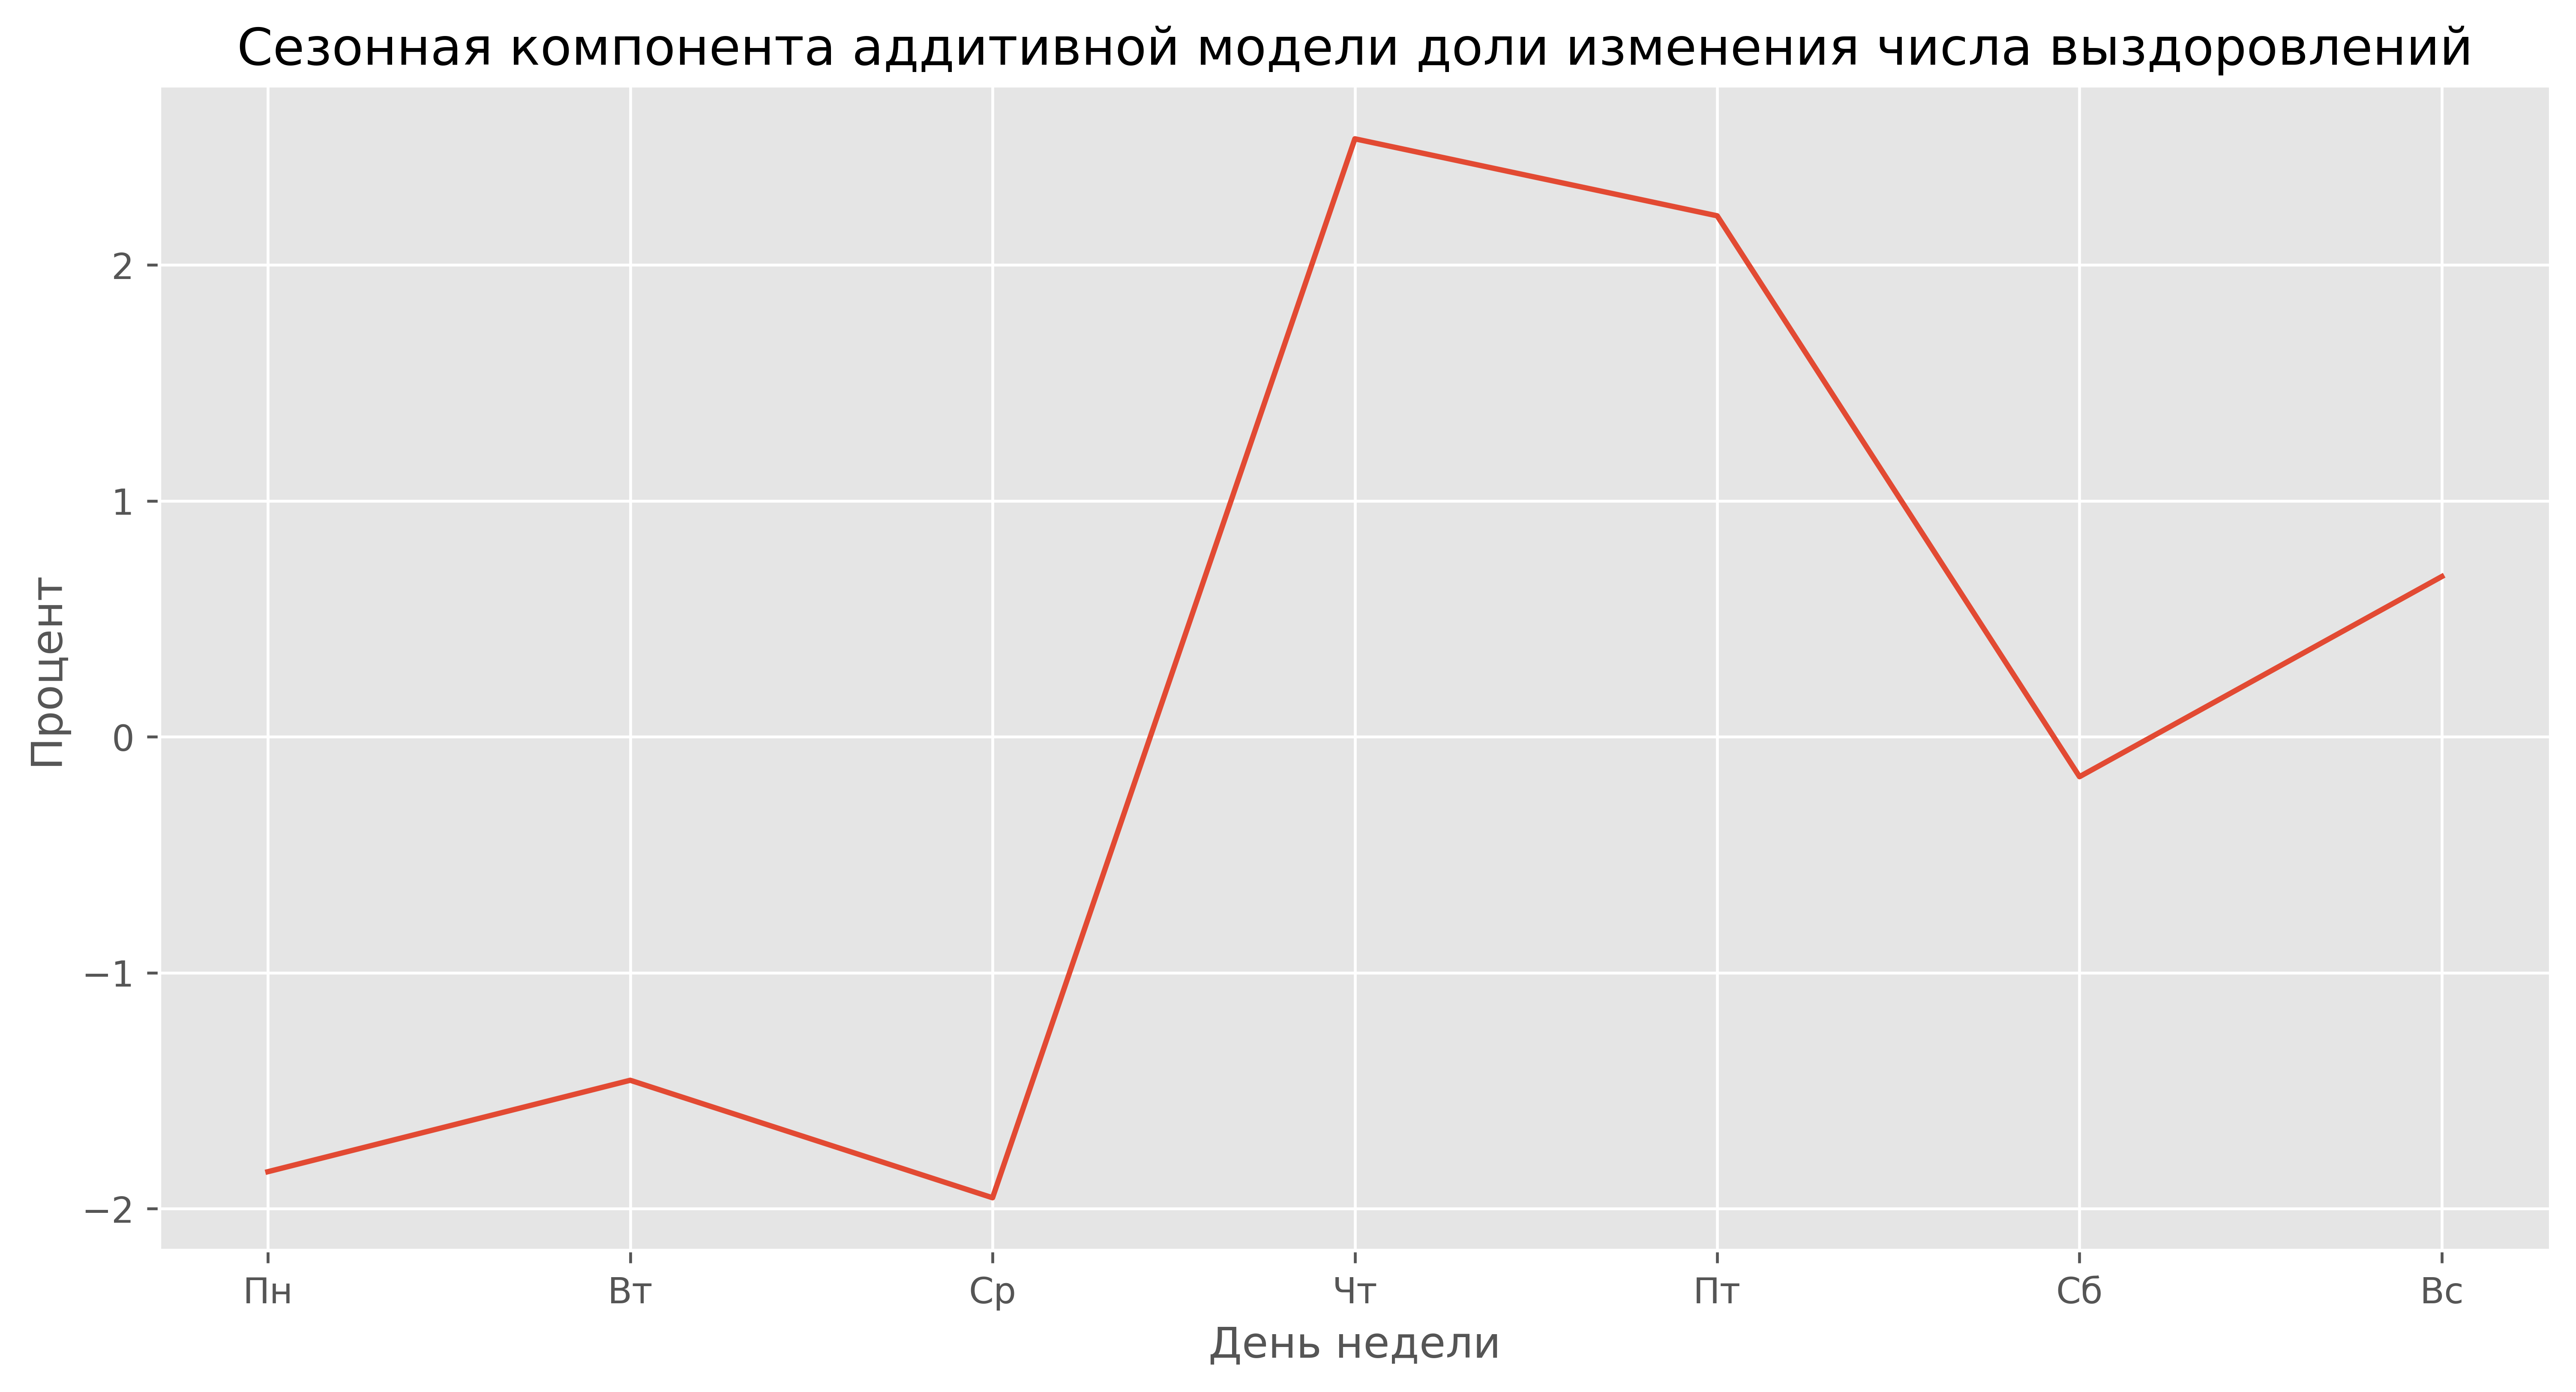

In [7]:
p = add_seasonal.plot()
p.set_title('Сезонная компонента аддитивной модели доли изменения числа выздоровлений')
p.set_ylabel('Процент')
p.set_xlabel('День недели')
p.set_xticks(list(range(7)))
p.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
p

Заметим, что абсолютное изменение доли числа выздоровлений минимально в среду и максимально в четверг.

Проверим стационарность остатков после удаления сезонной компоненты

Text(0.5, 0, 'День')

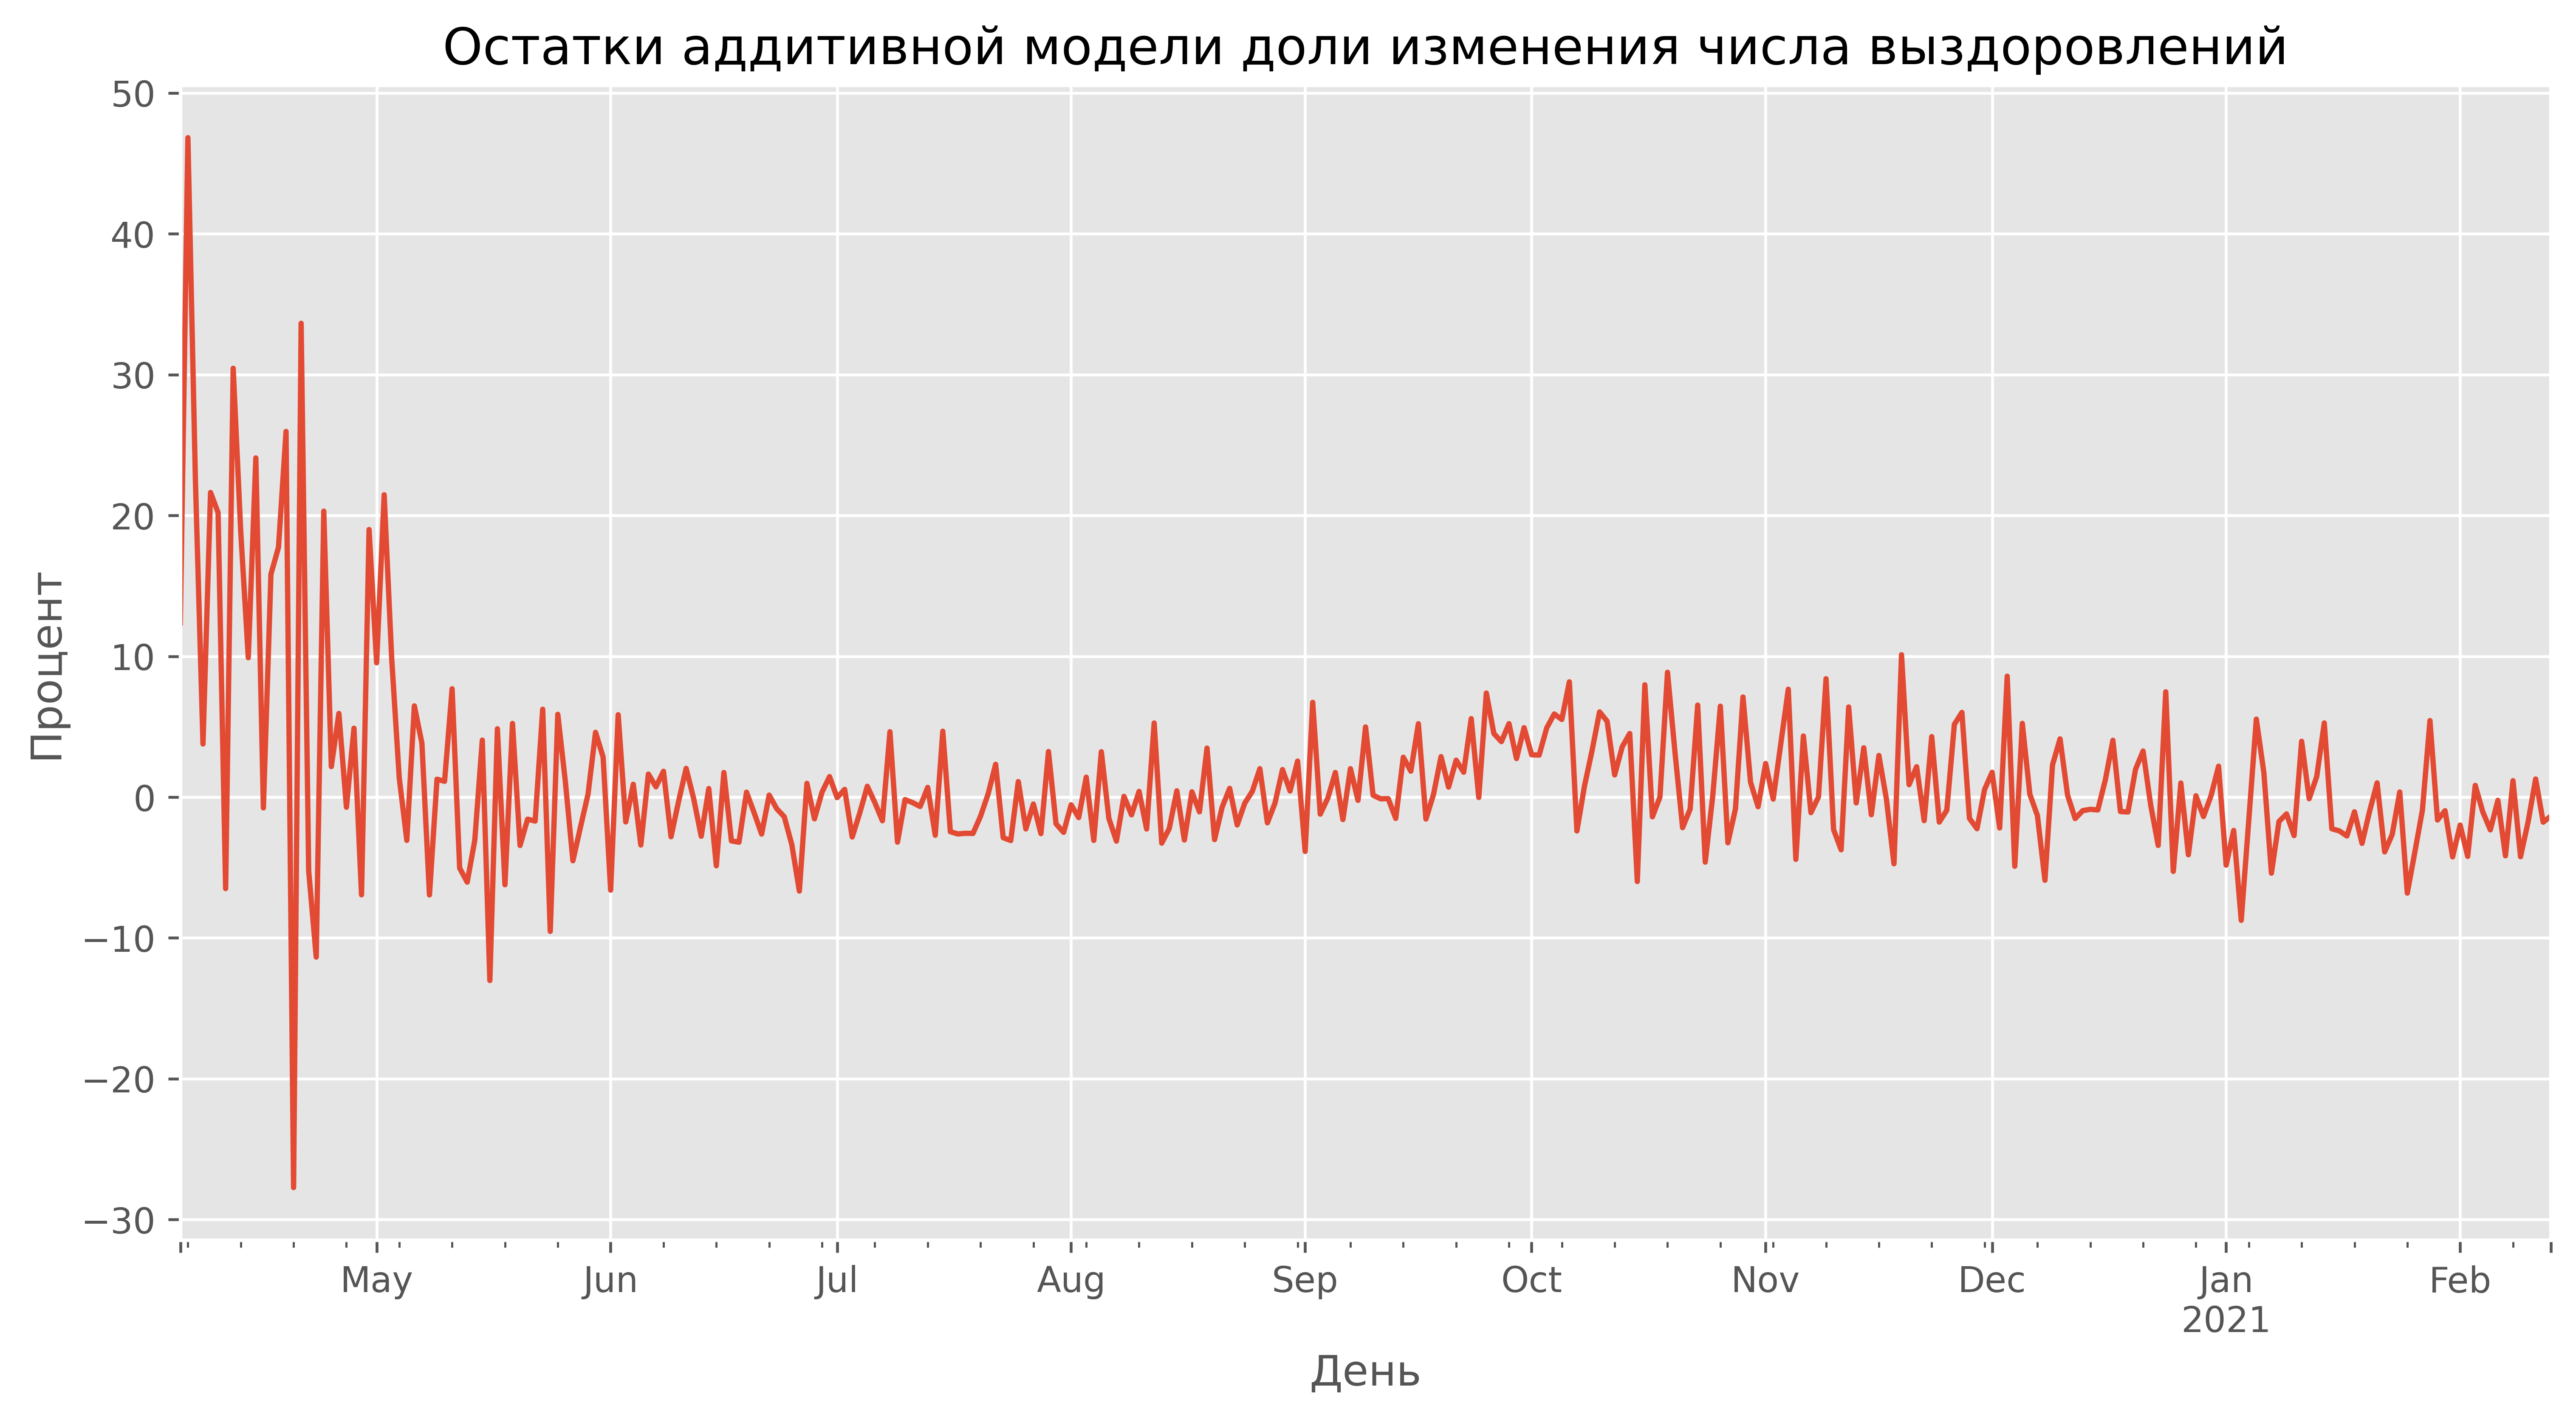

In [8]:
p = add_residuals.plot()
p.set_title('Остатки аддитивной модели доли изменения числа выздоровлений')
p.set_ylabel('Процент')
p.set_xlabel('День')

Судя по графику в целом временной ряд остатков гетероскедестичен. Однако с июня 2020 временной ряд похож на стационарный.

Проверим гипотезу о наличии единичного корня с помощью теста Дики-Фуллера с максимальным лагом равным периоду сезонности – одной неделе. Установим уровень значимости равным 0.05.

In [9]:
pvalue = adfuller(add_residuals.dropna(), maxlag=7)[1]
print(f'P-value: {pvalue}')

P-value: 0.000209754581541197


Значение p-value меньше установленного уровня значимости, поэтому гипотеза о наличии единичного корня отвергается. Следовательно, ряд остатков можно считать стационарным.

## Мультипликативная модель

Построим мультипликативную модель для временного ряда с периодом, равным одной неделе. Заметим, что процент изменения количества выздоровлений принимает значения на отрезке [-100, 100]. Для построения мультипликативной модели линейным смещением перенесем значения на отрезок [0, 200]. 

In [10]:
shifted_recovered_diff_perc = recovered_diff_perc.map(lambda x: x + 100)
mult_model = seasonal_decompose(shifted_recovered_diff_perc, model='multiplicative', period=7)
mult_seasonal = group_seasonal_component(mult_model.seasonal)
mult_residuals = shifted_recovered_diff_perc / mult_model.seasonal

<AxesSubplot:title={'center':'Сезонная компонента мультипликативной модели доли изменения числа выздоровлений'}, xlabel='День недели', ylabel='Коэффициент'>

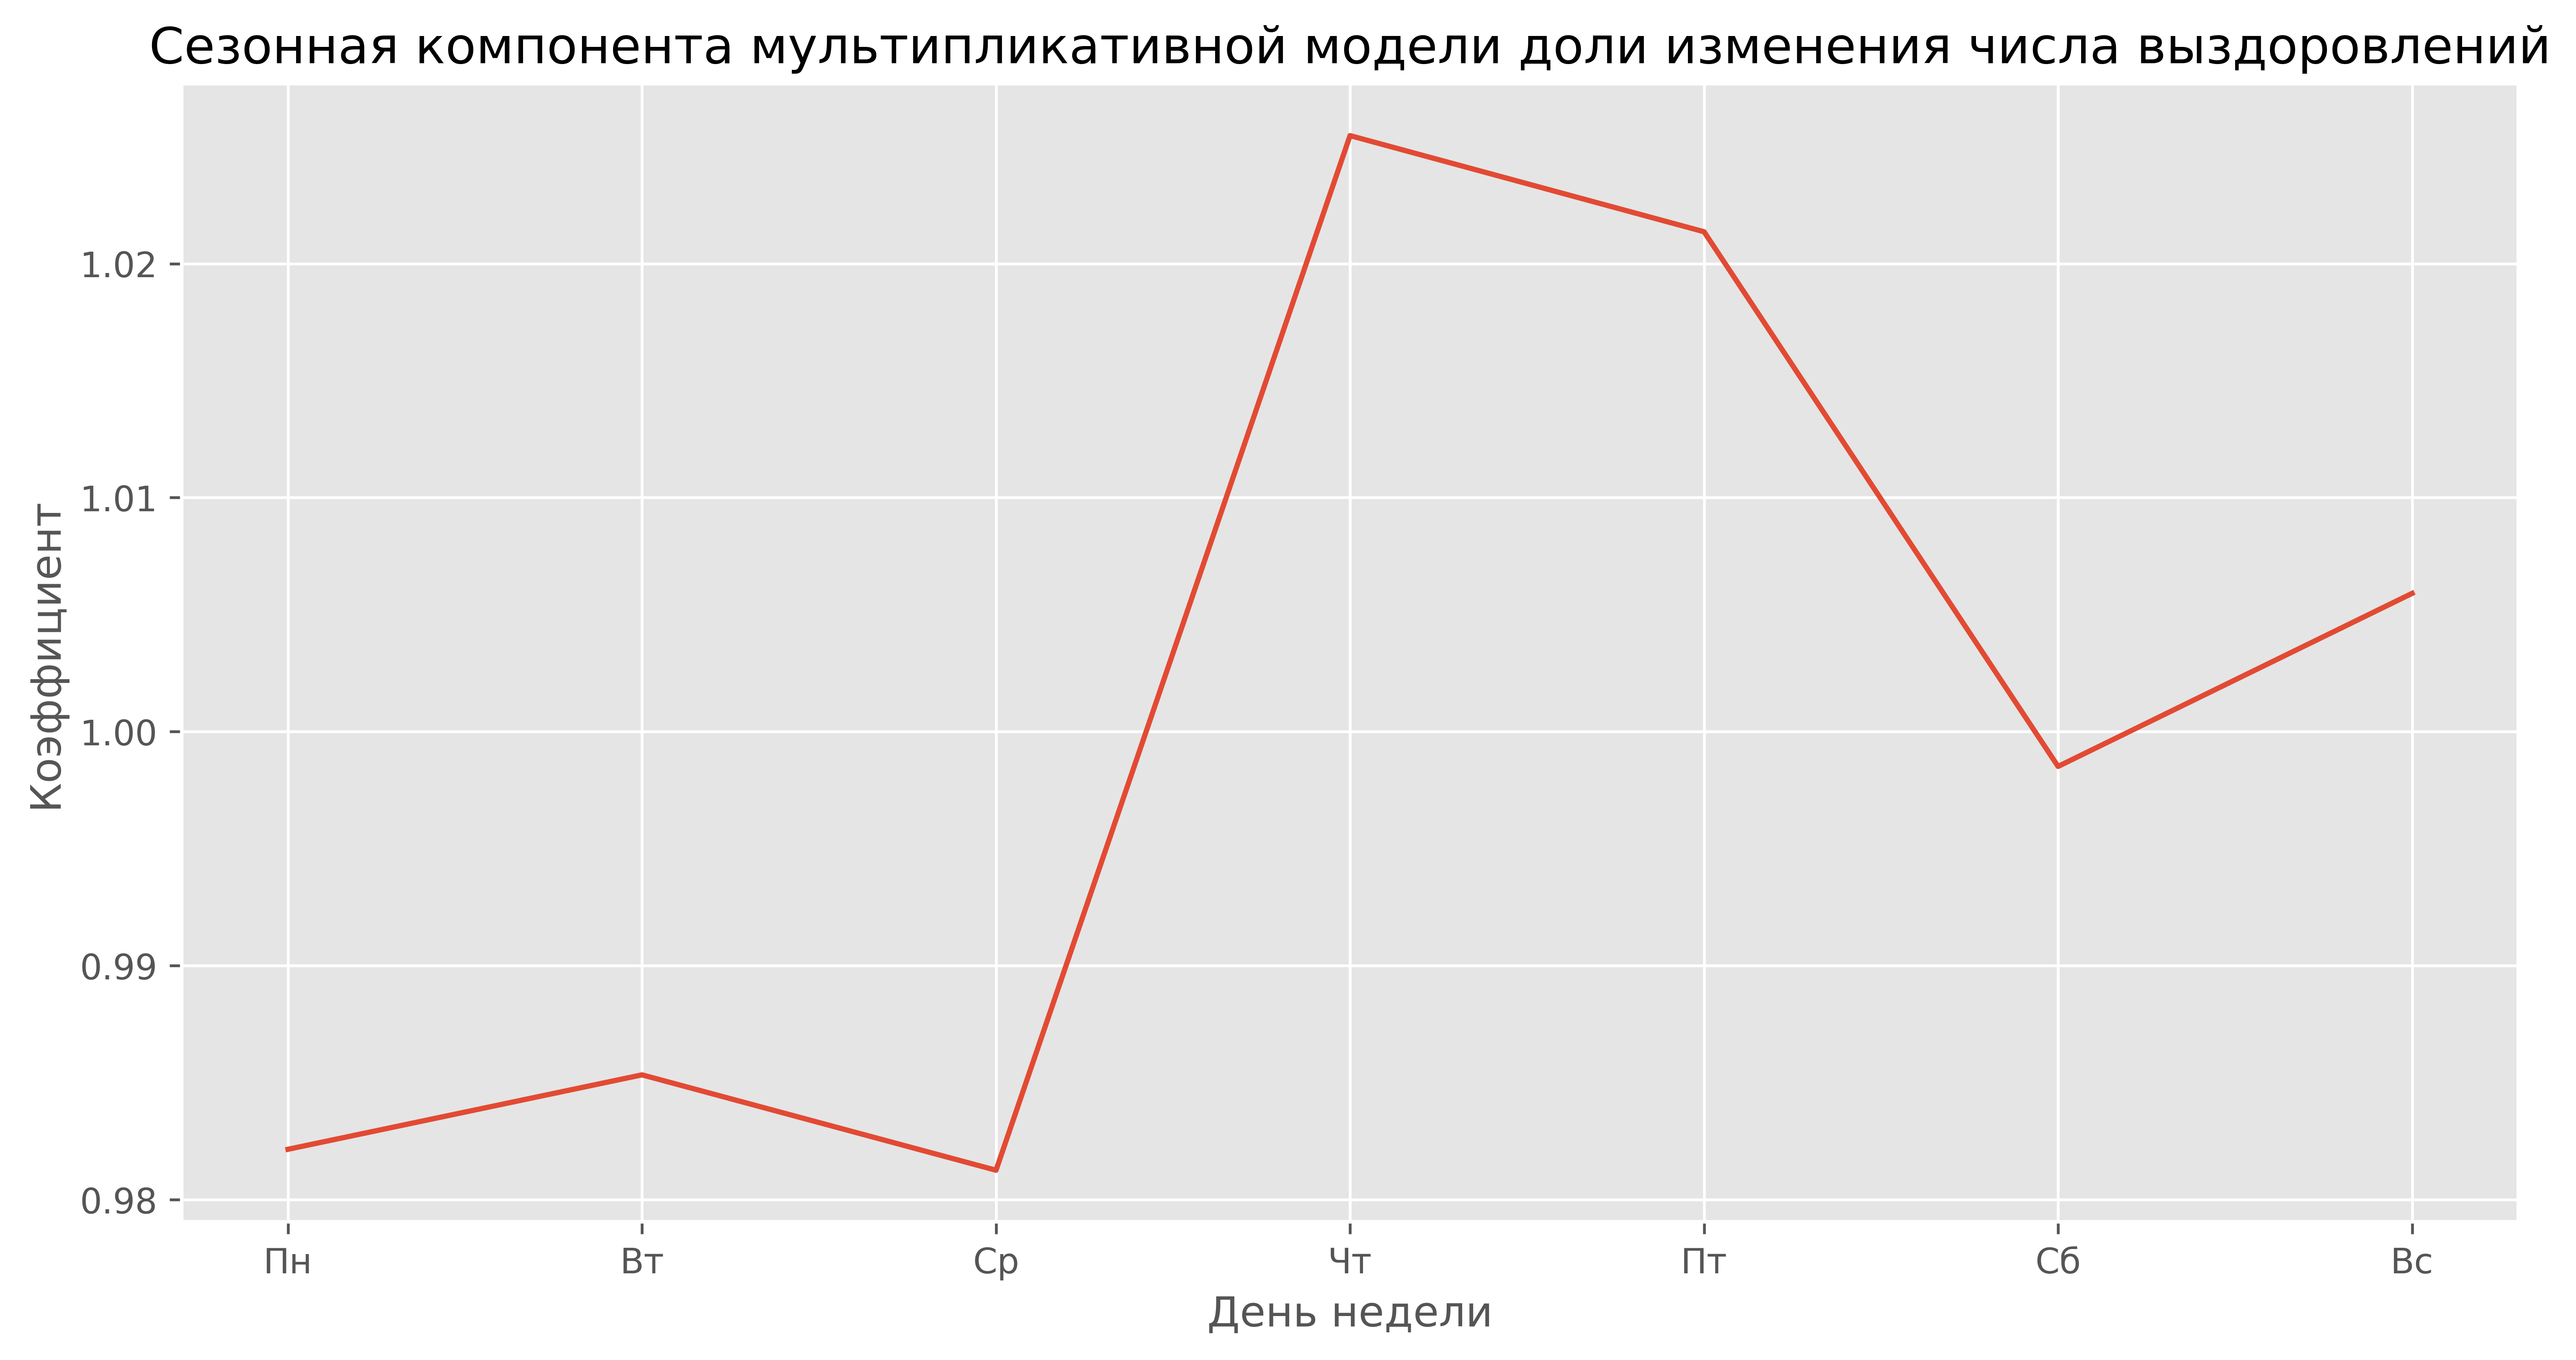

In [11]:
p = mult_seasonal.plot()
p.set_title('Сезонная компонента мультипликативной модели доли изменения числа выздоровлений')
p.set_ylabel('Коэффициент')
p.set_xlabel('День недели')
p.set_xticks(list(range(7)))
p.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
p

Заметим, что процентное изменение доли числа выздоровлений, как и абсолютное, минимально в среду и максимально в четверг.

Проверим стационарность остатков после удаления сезонной компоненты.

Text(0.5, 0, 'День')

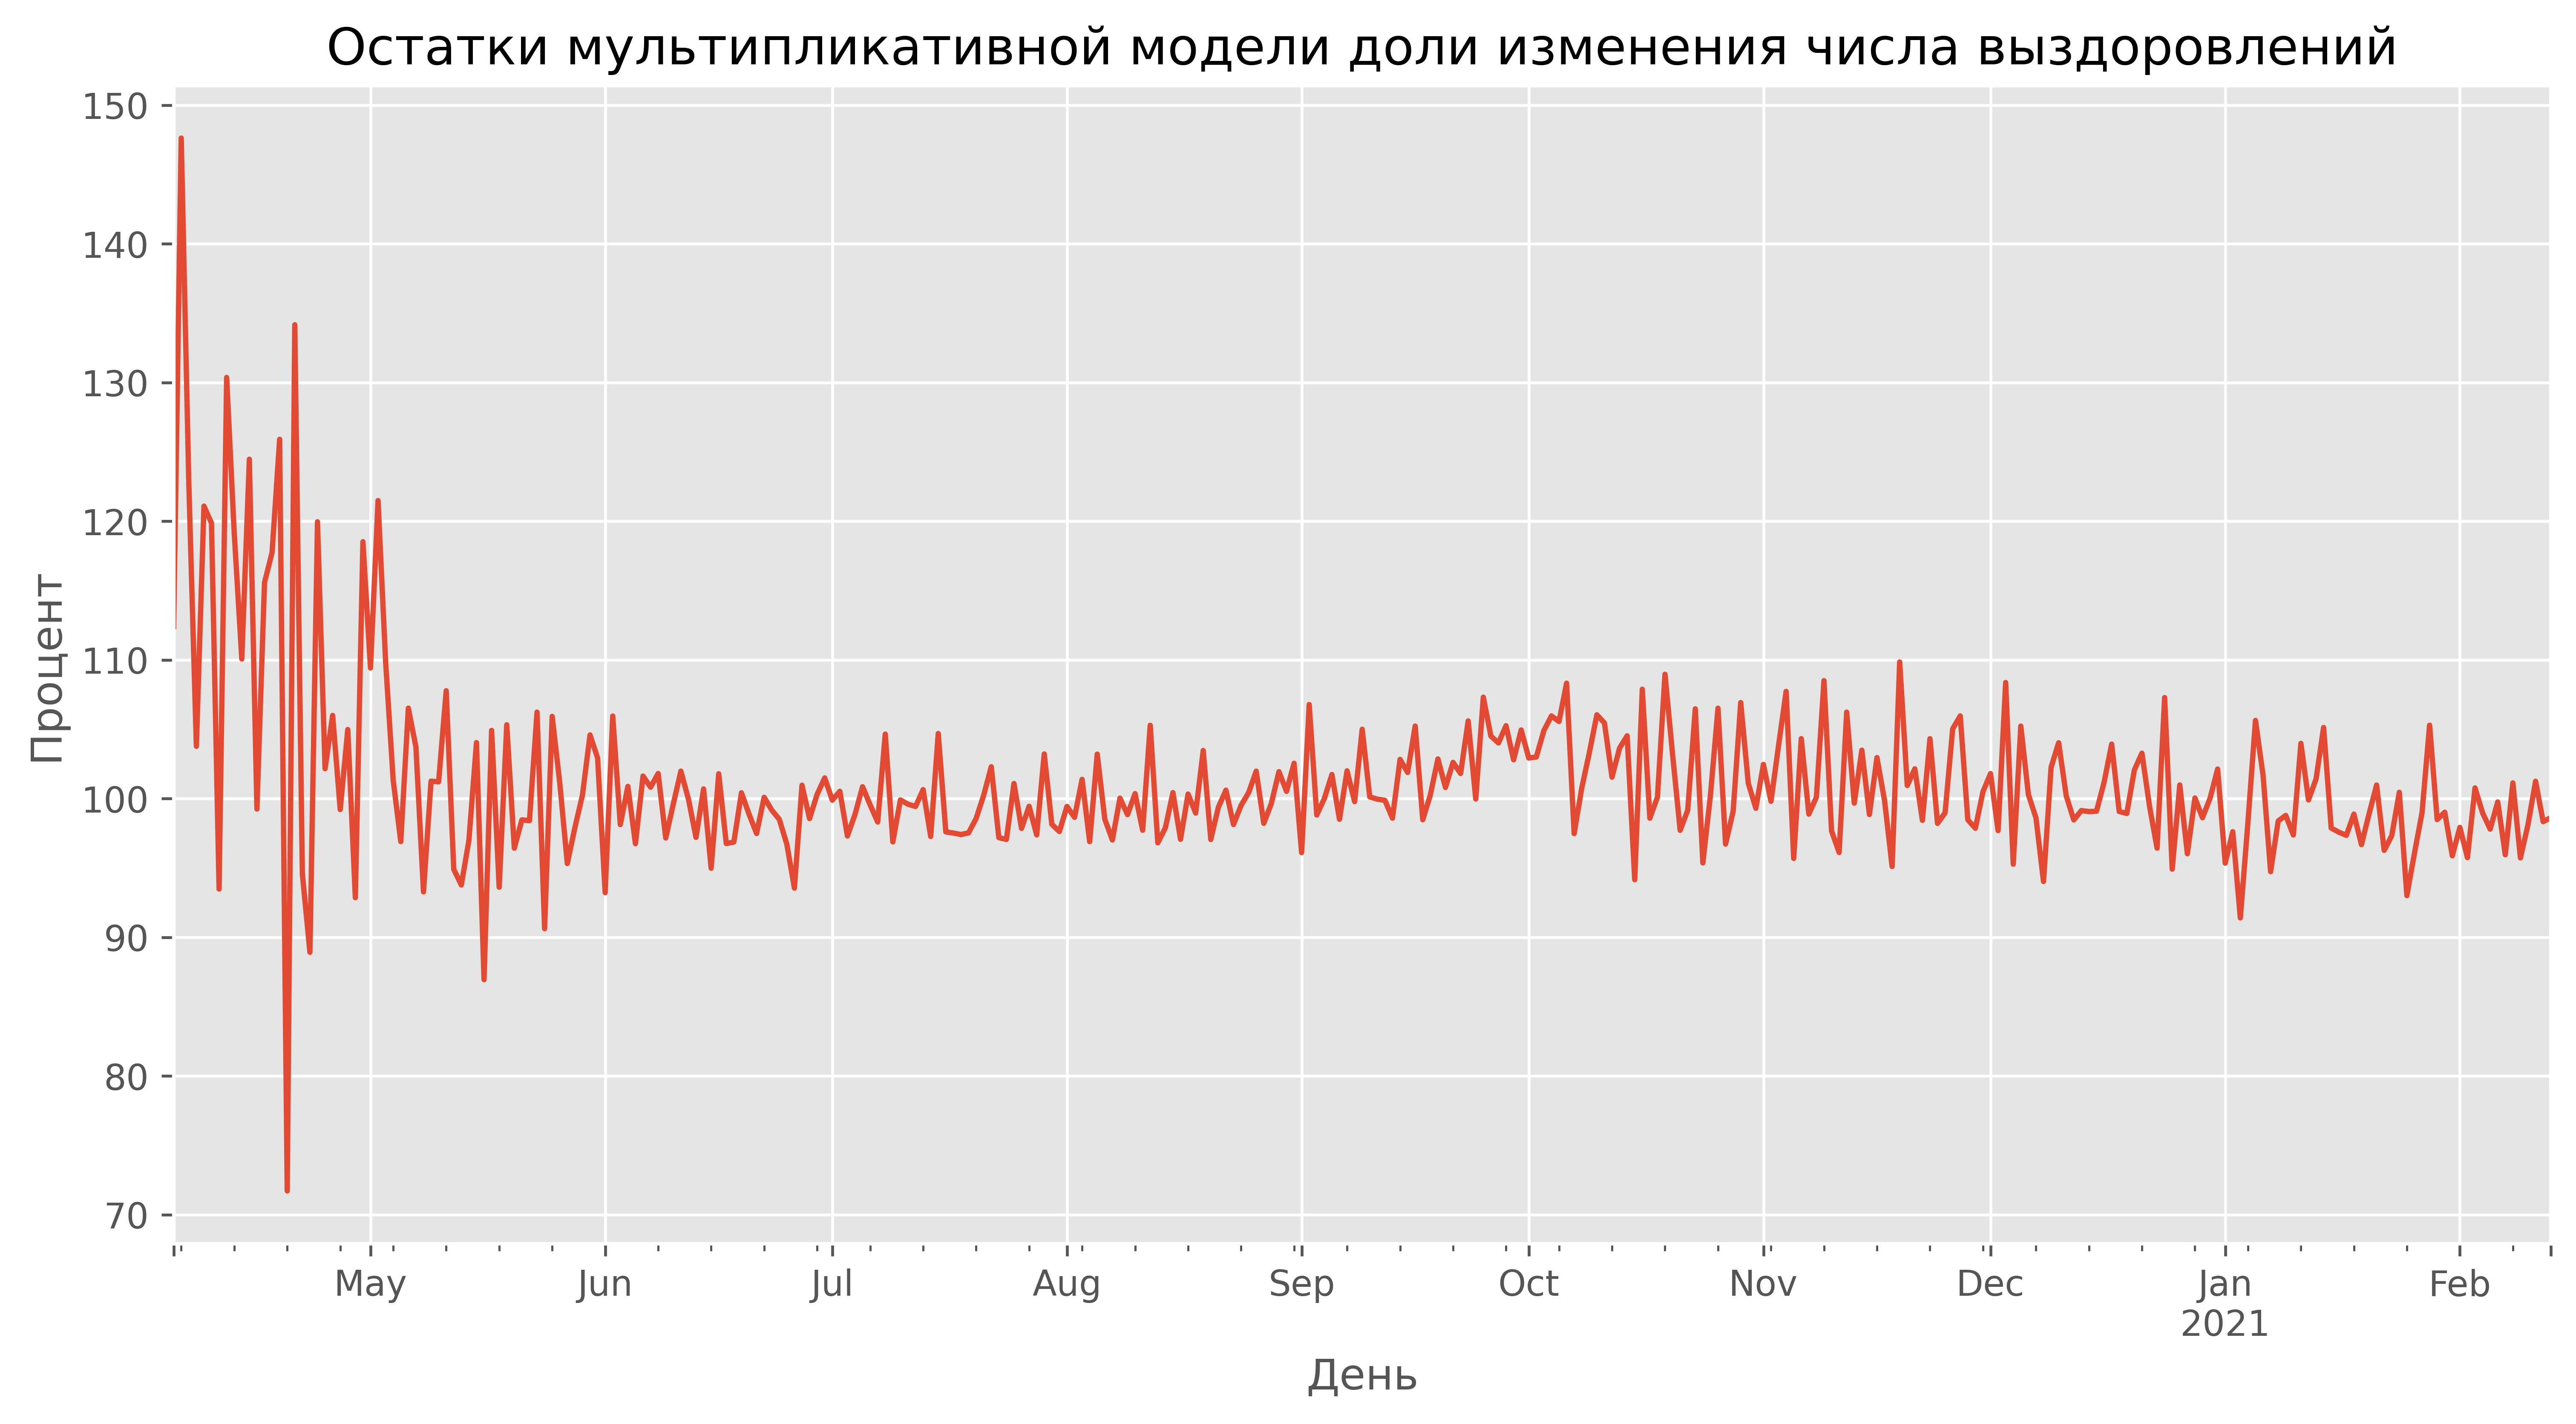

In [12]:
p = mult_residuals.dropna().plot()
p.set_title('Остатки мультипликативной модели доли изменения числа выздоровлений')
p.set_ylabel('Процент')
p.set_xlabel('День')

Как и в случае аддитивной модели в целом временной ряд остатков гетероскедестичен. С июня 2020 временной ряд похож на стационарный с небольшим трендом.

Проверим гипотезу о наличии единичного корня с помощью теста Дики-Фуллера с максимальным лагом равным периоду сезонности – одной неделе. Установим уровень значимости равным 0.05.

In [13]:
pvalue = adfuller(mult_residuals.dropna(), maxlag=7)[1]
print(f'P-value: {pvalue}')

P-value: 0.00022770977173019563


Значение p-value меньше установленного уровня значимости, поэтому гипотеза о наличии единичного корня отвергается. Следовательно, ряд остатков можно считать стационарным.